### TRIEST Algorithm Comparison: Base vs. Improved

#### Base Algorithm
**Adding edge e:**
```
if t <= M:
    insert e into S
    increase D
else:
    if weighted coin flip = tails:
        replace random edge e_r in S with e
        decrease D by triangles involving e_r
        increase D by triangles involving e
```

**Estimate at time t:**

If $t < M$, estimate is D. Otherwise, if $a < b$, then estimate is $\frac{D}{\pi_t}$ with $\pi_t = \frac{t-3 \choose M-3}{t \choose M}$

#### Improved Algorithm
**Adding edge e:**
```
count triangles g which e belongs to
increment D by g * eta_t
add (or not) e to S using reservoir sampling
```
note: eta_t = $\frac{(t-1)(t-2)}{M(M-1)}$

**Estimate at time t:**

 The estimate for number of triangles is always D.

#### Notes
**Differences between algorithms:**

The base algorithm has two main weaknesses:
- Triangle estimate can decrease over time, which doesn't make sense as we never remove edges
- Only counts triangles if all three edges are in S

By adding neighbors to triangle count for each datastream edge, and not decreasing the count when removing edges from S, the improved algorithm solves both issues.

**My implementation:**

For simplicity, I decided to store my sample as an array of Edge objects. This means adding and removing from the sample is very easy, but it also makes computing neighbors of a given edge more time consuming (as opposed to a data structure which tracks the edges coming out of each node). While I didn't track runtimes for this evaluation, I would expect that the cost of calculating neighbors would lead to some different patterns for the different algorithms. I expect that runtimes would be generally higher for the improved algorithm, which computes neighbors for each incoming edge, and that the runtime for both would increase with sample size. 

In [ ]:
# data collection
import os

times = [t for t in range(1, 198111)]
base = {ssize : {time : [] for time in range(1, 198111)} for ssize in [5000, 10000, 20000, 30000, 40000]}
impr = {ssize : {time : [] for time in range(1, 198111)} for ssize in [5000, 10000, 20000, 30000, 40000]}

# note: output files are in format: {input file}_{b / i}_{ssize}_{iteration}
for file in [f for f in os.listdir("./output")]:
    with open (os.path.join("./output", file), 'r') as f:
        for n, est in enumerate(f, start=1):
            if(file.split("_")[1]) == 'b':
                base[int(file.split("_")[2])][int(n)].append(int(est.strip()))
            else:
                impr[int(file.split("_")[2])][int(n)].append(int(est.strip()))

In [ ]:
# methods
import numpy as np
import matplotlib.pyplot as plt

def getmins(data, ssize):
    mins = []
    for t in times:
        mins.append(min(data[ssize][t]))
    return mins

def getmax(data, ssize):
    maxs = []
    for t in times:
        maxs.append(max(data[ssize][t]))
    return maxs

def getquartile(data, ssize, quartile):
    quartiles = []
    for t in times:
        quartiles.append(np.percentile(data[ssize][t], quartile))
    return quartiles

def doubleplot(data1, alabel1, data2, alabel2, ssize, slabel):
    colors = plt.get_cmap('Set3').colors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.scatter(times, getmins(data1, ssize), s=5, label="Minimum", color=colors[0])
    ax1.scatter(times, getmax(data1, ssize), s=5, label="Maximum", color=colors[7])
    ax1.scatter(times, getquartile(data1, ssize, 25), s=5, label="1st Quartile", color=colors[2])
    ax1.scatter(times, getquartile(data1, ssize, 50), s=5, label="Median", color=colors[3])
    ax1.scatter(times, getquartile(data1, ssize, 75), s=5, label="3rd Quartile", color=colors[4])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Estimate for Number of Triangles")
    ax1.set_title(f"{alabel1} Triest Estimate vs. Time for Sample Size {slabel}")

    ax2.scatter(times, getmins(data2, ssize), s=5, color=colors[0])
    ax2.scatter(times, getmax(data2, ssize), s=5, color=colors[7])
    ax2.scatter(times, getquartile(data2, ssize, 25), s=5, color=colors[2])
    ax2.scatter(times, getquartile(data2, ssize, 50), s=5, color=colors[3])
    ax2.scatter(times, getquartile(data2, ssize, 75), s=5, color=colors[4])
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Estimate for Number of Triangles")
    ax2.set_title(f"{alabel2} Triest Estimate vs. Time for Sample Size {slabel}")

    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=5)
    plt.tight_layout() 
    plt.show()

### Results

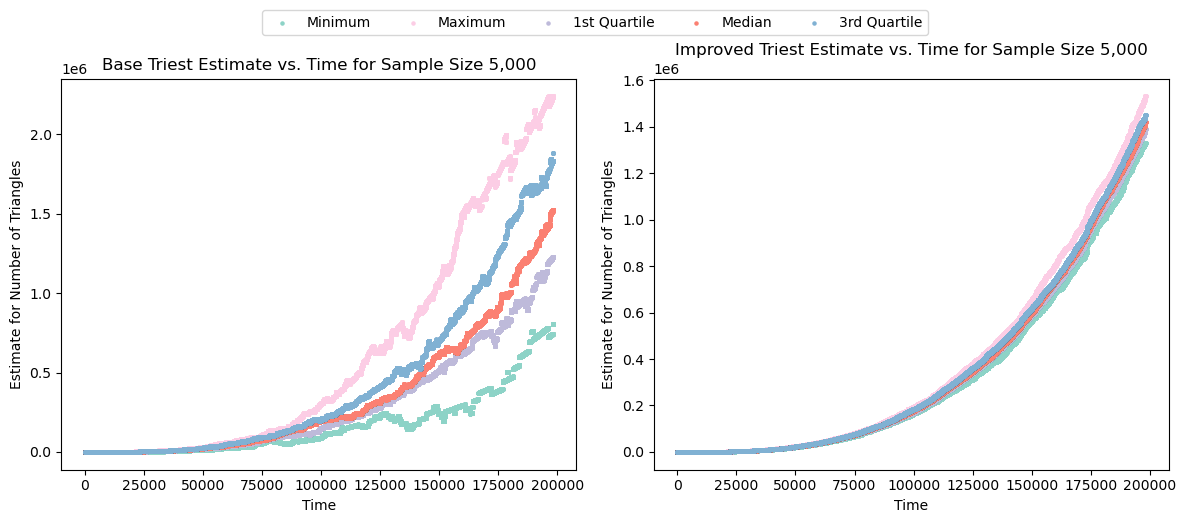

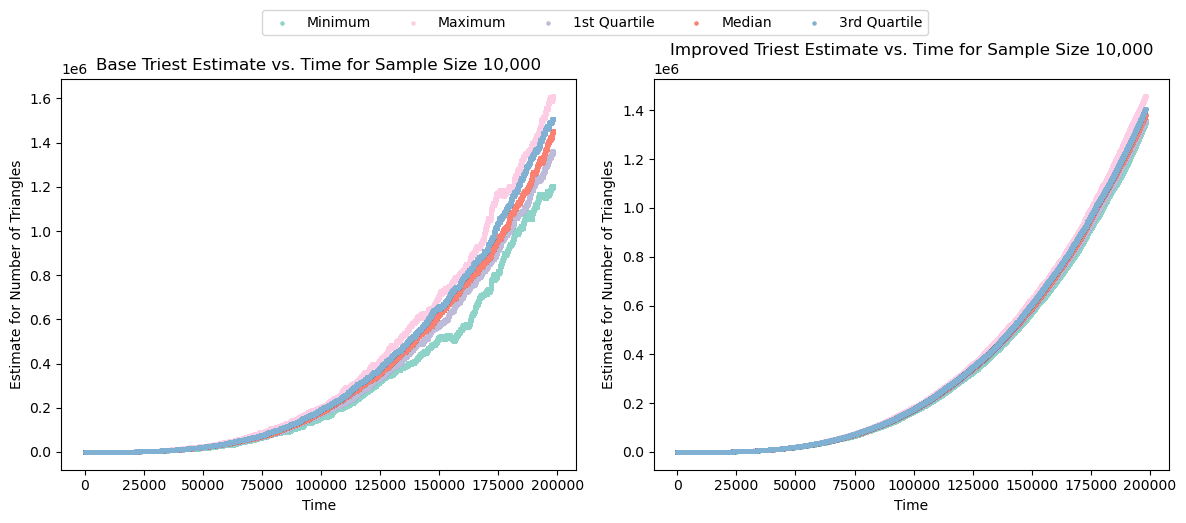

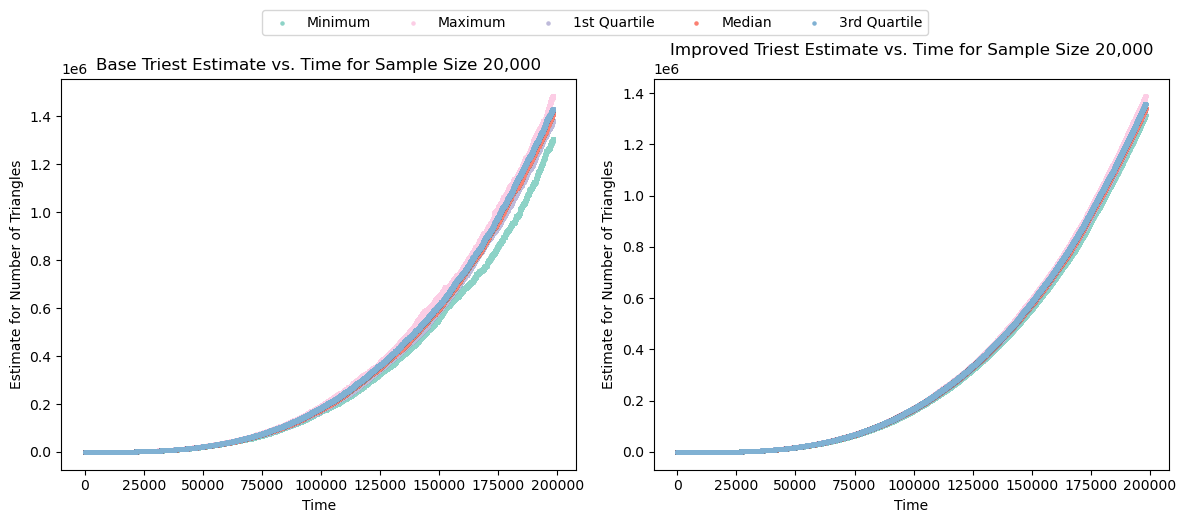

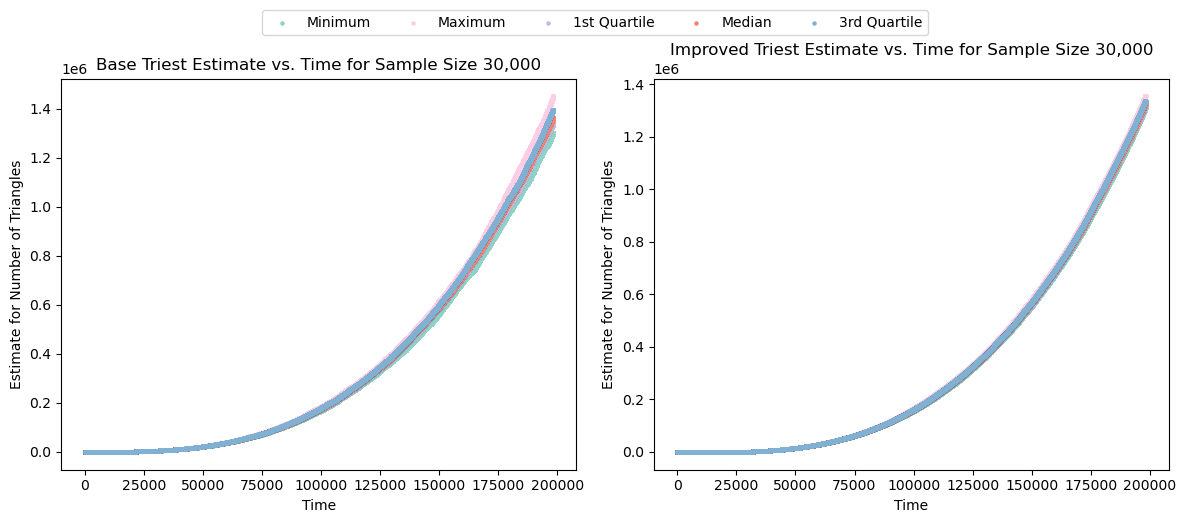

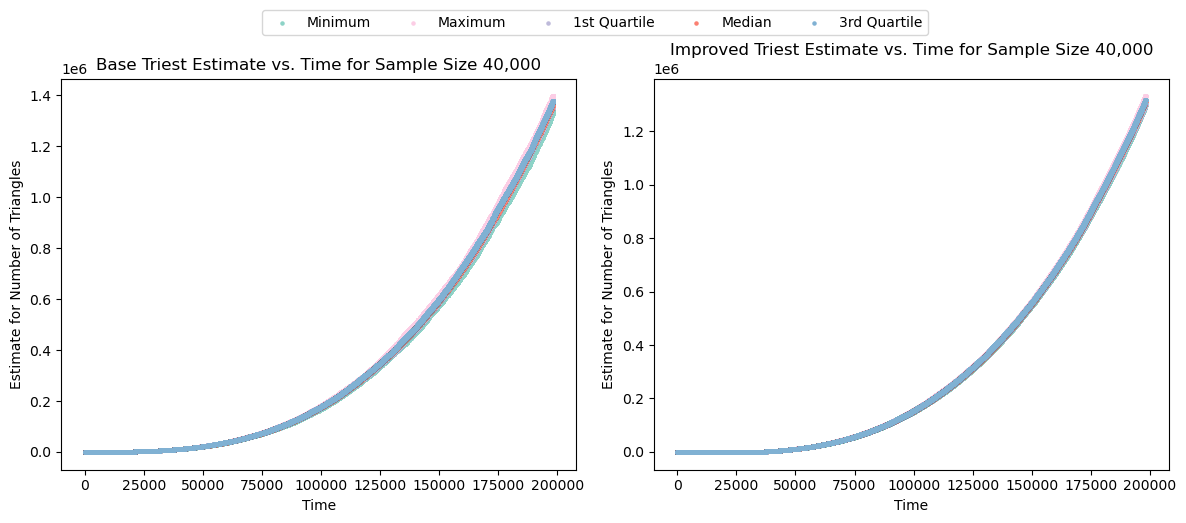

In [ ]:
# plots 
doubleplot(base, "Base", impr, "Improved", 5000, "5,000")
doubleplot(base, "Base", impr, "Improved", 10000, "10,000")
doubleplot(base, "Base", impr, "Improved", 20000, "20,000")
doubleplot(base, "Base", impr, "Improved", 30000, "30,000")
doubleplot(base, "Base", impr, "Improved", 40000, "40,000")

#### Analysis

Results are shown with the left column being the base algorithm, right is improved, and sample size increases moving downward through the rows. As sample size increases, both algorithms seem to converge to the exact value of number of triangles, which I found to be 1,351,441 using the NetworkX library. Given this and the max, min, and quartiles are pretty symmetrically distributed around the median, both algorithms appear to give correct and unbiased estimates for sample size. 

For both Base and Improved algorithms, and for all sample sizes, we can see that all curves follow a similar pattern of number of triangles increasing with time. Also shared between the implementations is a decrease in the variation between minimum, maximum, and median values as sample size increases. While the results for very large sample sizes are pretty similar for both algorithms, there is a very clear difference between the quality of the algorithms for smaller sample sizes--for sample size of 5,000, the difference between base algorithm's min and max for the final value of time is about seven times larger than that of the improved algorithm!